<a href="https://colab.research.google.com/github/namnitha/CE888-Data-Science/blob/master/Project/Google_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import os
import json
from pandas.io.json import json_normalize

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "namnitha" # username from the json file
os.environ['KAGGLE_KEY'] = "90ceb5b09eaa184f556d4577eb017b49" # key from the json file
!kaggle competitions download -c ga-customer-revenue-prediction # api copied from kaggle

  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 84.1MB/s]
 94% 315M/333M [00:05<00:00, 56.9MB/s]
100% 333M/333M [00:05<00:00, 64.9MB/s]
100% 1.11G/1.11G [00:16<00:00, 34.5MB/s]
100% 1.11G/1.11G [00:16<00:00, 72.8MB/s]
 86% 49.0M/56.8M [00:01<00:00, 26.8MB/s]
100% 56.8M/56.8M [00:01<00:00, 35.6MB/s]
 96% 5.00M/5.23M [00:00<00:00, 26.0MB/s]
100% 5.23M/5.23M [00:00<00:00, 25.3MB/s]
 79% 48.0M/61.1M [00:00<00:00, 33.9MB/s]
100% 61.1M/61.1M [00:00<00:00, 70.0MB/s]


In [0]:
!ls

sample_data		      test.csv.zip     train_v2.csv.zip
sample_submission.csv.zip     test_v2.csv.zip
sample_submission_v2.csv.zip  train.csv.zip


In [0]:
from zipfile import ZipFile
file_name = "train.csv.zip"
file_name = "test.csv.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


Loading the train and test data



In [0]:
def load_df(csv_path='train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [0]:
print('Loading Train set...')
train = load_df()

Loading Train set...
Loaded train.csv. Shape: (903653, 55)


In [0]:
print('Loading Test set...')
test = load_df("test.csv")

Loading Test set...
Loaded test.csv. Shape: (804684, 53)


In [0]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not ava

In [0]:
test.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.newVisits,totals.bounces,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.referralPath,trafficSource.adContent
0,Organic Search,20171016,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Southeast Asia,Singapore,(not set),(not set),(not set),not available in demo dataset,myrepublic.com.sg,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,4,4,NaN,NaN,(not set),google,organic,(not provided),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20171016,0643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Aragon,(not set),Zaragoza,not available in demo dataset,rima-tde.net,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,5,5,1,NaN,(not set),google,organic,(not provided),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20171016,6059383810968229466,6059383810968229466_1508143220,Not Socially Engaged,1508143220,1,1508143220,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Western Europe,France,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,sfr.net,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,7,7,1,NaN,(not set),google,organic,(not provided),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20171016,2376720078563423631,2376720078563423631_1508193530,Not Socially Engaged,1508193530,1,1508193530,Safari,not available in demo dataset,not available in demo dataset,iOS,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in dem

Plotting histograms for random columns in comparision with the train vs test colums

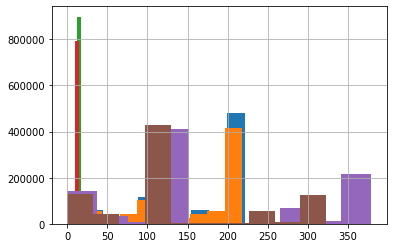

In [0]:
train['geoNetwork.country'].hist() 
test['geoNetwork.country'].hist()
train["trafficSource.adContent"].hist() 
test['trafficSource.adContent'].hist()
train["trafficSource.source"].hist() 
test['trafficSource.source'].hist()

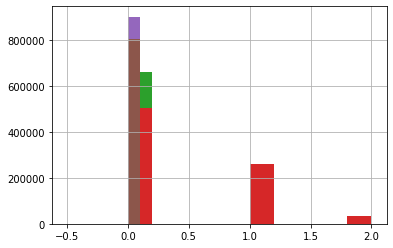

In [0]:
train['device.browserVersion'].hist() 
test['device.browserVersion'].hist()
train["device.deviceCategory"].hist() 
test['device.deviceCategory'].hist()
train["device.flashVersion"].hist() 
test['device.flashVersion'].hist()

In [0]:
print('Imputing missing values...')
for i in train.columns:
    if train[i].dtype == 'object':
      train[i] = train[i].fillna(train[i].mode().iloc[0])
    elif (train[i].dtype != 'object'):
      train[i] = train[i].fillna(np.mean(train[i]))


for i in test.columns:
    if test[i].dtype == 'object':
      test[i] = test[i].fillna(test[i].mode().iloc[0])
    elif (test[i].dtype != 'object'):
      test[i] = test[i].fillna(np.mean(test[i]))
    

print('Nulls in train set:', train.isnull().sum().sum())
print('Nulls in test set:', test.isnull().sum().sum())

Imputing missing values...
Nulls in train set: 0
Nulls in test set: 0


In [0]:
print('Label Encoding categorical variables...')
for col in train.columns:
    if train[col].dtype == 'object':
      train[col] = train[col].astype('category')
      train[col] = train[col].cat.codes

for col in test.columns:
    if test[col].dtype == 'object':
      test[col] = test[col].astype('category')
      test[col] = test[col].cat.codes

Label Encoding categorical variables...


In [0]:
train['set'] = 0
test['set'] = 1
train = train.drop(['totals.transactionRevenue', 'trafficSource.campaignCode'],axis=1)

In [0]:
train_df = train.sample(10000, random_state=697)
test_df = test.sample(10000, random_state=466)

all_data = train_df.append(test_df)
y_label = all_data['set']
all_data = all_data.drop('set',axis=1)

#Making sure that the new dataframe contains all the initial features
print('New dataframe shape:', all_data.shape)

New dataframe shape: (20000, 53)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


###Interpreting the results
Output of the ROC-AUC metric for our classifier as an estimation of how much covariate shift this data has.

If the classifier is able to classify the rows into train and test with good accuracy, our AUC score should be on the higher side (greater than 0.8). This implies a strong covariate shift between train and test.

In [0]:
model = RandomForestClassifier(n_estimators = 50, max_depth = 5, min_samples_leaf = 5)
feat_to_drop = []
for col in all_data.columns:
    score = cross_val_score(model,pd.DataFrame(all_data[col]),y_label,cv=4,scoring='roc_auc')
    if np.mean(score) > 0.8:
        feat_to_drop.append(col)
    print(col,np.mean(score))

channelGrouping 0.57437524
date 1.0
device.browser 0.9993892200000001
device.browserSize 0.5
device.browserVersion 0.5
device.deviceCategory 0.55132108
device.flashVersion 0.5
device.isMobile 0.55175
device.language 0.5
device.mobileDeviceBranding 0.5
device.mobileDeviceInfo 0.5
device.mobileDeviceMarketingName 0.5
device.mobileDeviceModel 0.5
device.mobileInputSelector 0.5
device.operatingSystem 0.8913073
device.operatingSystemVersion 0.5
device.screenColors 0.5
device.screenResolution 0.5
fullVisitorId 0.57296068
geoNetwork.city 0.9603752
geoNetwork.cityId 0.5
geoNetwork.continent 0.52113994
geoNetwork.country 0.91596308
geoNetwork.latitude 0.5
geoNetwork.longitude 0.5
geoNetwork.metro 0.9417332199999999
geoNetwork.networkDomain 0.7918458199999999
geoNetwork.networkLocation 0.5
geoNetwork.region 0.70905394
geoNetwork.subContinent 0.54135148
sessionId 0.5608901799999999
socialEngagementType 0.5
totals.bounces 0.5
totals.hits 0.7679629199999999
totals.newVisits 0.5
totals.pageviews 0.8

In [0]:
print('Number of features with covariate shift:', len(feat_to_drop))

Number of features with covariate shift: 14


As we can see, classifier found reasonable difference between train data and test data. As per the considered threshold value, these AUC scores show that there are 14 features contain covariate shift.

As per the AUC score we attained from data, we can say that there is active covariate shift in the dataset.
